In [1]:
# %matplotlib qt 

# %matplotlib inline

import typing as T

import numpy as np
import numpy.typing as npt
import scipy as sp

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from pydrake.solvers import (  
    MathematicalProgram,
    MathematicalProgramResult,
    Solve,
)
from pydrake.symbolic import Polynomial, Variable, Variables

from util import timeit

from pydrake.math import eq, le, ge

FREE = "free"
PSD = "psd"
PSD_ON_REGION = "psd_on_region"

In [2]:
%matplotlib widget

In [59]:
class Vertex:
    def __init__(self, name:str, prog: MathematicalProgram, dim:int, pot_type:str=PSD_ON_REGION):
        self.n = dim
        self.name = name
        
        self.define_potential(prog, pot_type)

    def define_potential(self, prog: MathematicalProgram, pot_type:str):
        self.Q = prog.NewSymmetricContinuousVariables(self.n, "Q_" + self.name)
        if pot_type == PSD:
            prog.AddPositiveSemidefiniteConstraint(self.Q)
        elif pot_type == PSD_ON_REGION:
            prog.AddPositiveSemidefiniteConstraint(self.Q + np.eye(self.n)) 

        self.r = prog.NewContinuousVariables(self.n, "r_" + self.name)
        self.s = prog.NewContinuousVariables(1, "s_"+self.name)[0]

    def evaluate_partial_potential_at_point(self, x:npt.NDArray):
        assert len(x) == self.n
        return x.T @ self.Q @ x + 2*self.r.dot(x) + self.s
    
    def cost_at_point(self, x:npt.NDArray, solution:MathematicalProgramResult=None):
        if solution is None:
            return self.evaluate_partial_potential_at_point(x)
        else: 
            Q, r, s = solution.GetSolution(self.Q), solution.GetSolution(self.r), solution.GetSolution(self.s)
            return x.T @ Q @ x + 2*r.dot(x) + s
        

class Edge:
    def __init__(self, v_left: Vertex, v_right: Vertex):
        self.left = v_left
        self.right = v_right
        self.n = self.left.n
        assert self.left.n == self.right.n
        self.name = self.left.name + " " + self.right.name

    def get_potential_diff_quadratic(self):
        n = self.n

        Ql = self.left.Q
        Qr = self.right.Q
        rl = self.left.r.reshape(n,1)
        rr = self.right.r.reshape(n,1)
        sl = self.left.s
        sr = self.right.s

        In = np.eye(n)

        return np.vstack((
            np.hstack( (np.array([[sr - sl]]), -rl.T, rr.T) ), 
            np.hstack( (-rl, In - Ql, -In ) ), 
            np.hstack( (rr, -In, Qr+In ) ) 
            ))

In [148]:
class BoxVertex(Vertex):
    def __init__(self, name:str, prog: MathematicalProgram, lb:npt.NDArray, ub:npt.NDArray, pot_type=PSD_ON_REGION):
        assert len(lb) == len(ub)        
        super(BoxVertex, self).__init__(name, prog, len(lb), pot_type)
        self.lb = lb.reshape(self.n,1)
        self.ub = ub.reshape(self.n,1)
        self.A = np.vstack((-np.eye(self.n), np.eye(self.n)))
        self.b = np.vstack((-self.lb, self.ub))
        self.center = ((self.lb+self.ub)/2.0).reshape(self.n)

    def cost_at_center(self, solution:MathematicalProgramResult = None):
        x = self.center
        return self.cost_at_point(x, solution)


class BoxEdge(Edge):
    def __init__(self, v_left: BoxVertex, v_right: BoxVertex, prog: MathematicalProgram):
        super(BoxEdge, self).__init__(v_left, v_right)
        self.s_procedure(prog)

    
    def get_set_quadratic(self, prog:MathematicalProgram):
        # construct a big Ax <= b
        A1 = self.left.A
        A2 = self.right.A

        m1,n1 = A1.shape
        m2,n2 = A2.shape
        A = np.vstack( (
            np.hstack( ( A1, np.zeros((m1,n2)) ) ), 
            np.hstack( (np.zeros((m2,n1)), A2 ) ) 
            ))
        b = np.vstack((self.left.b, self.right.b))

        # define multipliers
        self.multiplier = prog.NewContinuousVariables(m1+m2, "lambda_"+self.name).reshape(m1+m2, 1)
        lambda_e = self.multiplier
        prog.AddLinearConstraint( ge(lambda_e, np.zeros(m1+m2) ) )

        return np.vstack( (
            np.hstack( (-lambda_e.T @ b, 0.5* lambda_e.T @ A ) ),
            np.hstack( ( 0.5* A.T @ lambda_e, np.zeros((2*self.n, 2*self.n)) ) )))


    def s_procedure(self, prog:MathematicalProgram):
        # print( self.get_set_quadratic(prog) )
        # print( self.get_potential_diff_quadratic() )

        M = self.get_set_quadratic(prog) + self.get_potential_diff_quadratic()
        prog.AddPositiveSemidefiniteConstraint( M )



In [150]:
def make_box_cycle(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):
    assert num_vertices >= 2
    prog = MathematicalProgram()
    vertices = []
    vt = BoxVertex("t", prog, -1*np.ones(n), 1*np.ones(n), pot_type)
    vertices.append( vt )

    # for i in range(num_vertices-2):
    vertices.append( BoxVertex("v"+str(1), prog, 2*np.ones(n), 4*np.ones(n), pot_type) )

    vs = BoxVertex("s", prog, 3*np.ones(n), 5*np.ones(n), pot_type)
    vertices.append( vs )


    for i in range( len(vertices)-1 ):
        BoxEdge( vertices[i+1], vertices[i], prog)
        # BoxEdge( vertices[i], vertices[i+1], prog)

    # BoxEdge( vs, vt, prog)
    # BoxEdge( vt, vs, prog)

    prog.AddLinearConstraint(vt.cost_at_center() == 0)
    cost = vs.cost_at_center()
    prog.AddLinearCost( -cost )
    return prog

prog = make_box_cycle(n=2, num_vertices=3, scaling = 1)
solution = Solve(prog)
print(solution.is_success())
print(solution.get_optimal_cost())

True
-15.999999979175538


In [121]:
class EllipsoidVertex(Vertex):
    def __init__(self, name:str, prog: MathematicalProgram, center:npt.NDArray, B:npt.NDArray, pot_type=PSD_ON_REGION):
        assert len(center) == B.shape[0] == B.shape[1]
        super(EllipsoidVertex, self).__init__(name, prog, len(center), pot_type)
        # {Bu + center | |u|_2 <= 1}
        self.B = B
        self.center = center
        # {x | (x-center).T A.T A (x-center) <= 1 }
        self.A = np.linalg.inv(B)
        # {x | (x-center).T G (x-center) <= 1 }
        self.G = self.A.T @ self.A

    def cost_at_center(self, solution:MathematicalProgramResult = None):
        x = self.center
        return self.cost_at_point(x, solution)


class EllipsoidEdge(Edge):
    def __init__(self, v_left: EllipsoidVertex, v_right: EllipsoidVertex, prog: MathematicalProgram):
        super(EllipsoidEdge, self).__init__(v_left, v_right)
        self.s_procedure(prog)
    
    def get_set_quadratic(self, prog:MathematicalProgram):
        n = self.n
        c1, G1 = self.left.center.reshape(n,1), self.left.G
        c2, G2 = self.right.center.reshape(n,1), self.right.G

        l1 = prog.NewContinuousVariables(1)[0]
        l2 = prog.NewContinuousVariables(1)[0]
        # l2 = l1
        prog.AddLinearConstraint(l1 >= 0)
        prog.AddLinearConstraint(l2 >= 0)


        return np.vstack( (
            np.hstack( (np.array([[l1*(c1.T @ c1 - 1) + l2*(c2.T @ c2 - 1)]]), -l1*c1.T @ G1, -l2*c2.T @ G2)),
            np.hstack( (-l1*G1@c1, l1 * G1,  np.zeros((n,n))) ),
            np.hstack( (-l2*G2@c2, np.zeros((n,n)), l2*G2 ) ) 
            ))
    

    def s_procedure(self, prog:MathematicalProgram):
        # print(self.get_set_quadratic(prog).shape)
        # print(self.get_potential_diff_quadratic().shape)
        M = self.get_set_quadratic(prog) + self.get_potential_diff_quadratic()
        prog.AddPositiveSemidefiniteConstraint( M )



In [104]:

# def make_ellipsoid_cycle(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):

n = 2
num_vertices = 2
pot_type = PSD_ON_REGION

prog = MathematicalProgram()
vertices = []
vt = EllipsoidVertex("t", prog, np.zeros(n), 1*np.eye(n), pot_type)
vertices.append( vt )

# vertices.append( EllipsoidVertex("v"+str(1), prog, 2*np.ones(n), 1*np.eye(n), pot_type) )

vs = EllipsoidVertex("s", prog, 2*np.ones(n), 1*np.eye(n), pot_type)
vertices.append( vs )

# for i in range( len(vertices)-1 ):
#     EllipsoidEdge( vertices[i+1], vertices[i], prog)
#     EllipsoidEdge( vertices[i], vertices[i+1], prog)

EllipsoidEdge( vs, vt, prog)
EllipsoidEdge( vt, vs, prog)

prog.AddLinearConstraint(vt.cost_at_center() == 0)
cost = vs.cost_at_center()
prog.AddLinearCost( -cost )
# return prog

solution = Solve(prog)
print(solution.is_success())
print(solution.get_optimal_cost())

True
-7.313708493462134


In [279]:
def make_ellipsoid_cycle(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):
    assert num_vertices >= 2
    prog = MathematicalProgram()
    vertices = []
    vt = EllipsoidVertex("t", prog, np.zeros(n), scaling*np.eye(n), pot_type)
    vertices.append( vt )

    for i in range(num_vertices-2):
        vertices.append( EllipsoidVertex("v"+str(i), prog, scaling*(2*i+2)*np.ones(n), scaling*np.eye(n), pot_type) )

    vs = EllipsoidVertex("s", prog, scaling*(2*(num_vertices-2)+2)*np.ones(n), scaling*np.eye(n), pot_type)
    vertices.append( vs )

    for i in range( len(vertices)-1 ):
        EllipsoidEdge( vertices[i+1], vertices[i], prog)
        EllipsoidEdge( vertices[i], vertices[i+1], prog)

    EllipsoidEdge( vs, vt, prog)
    EllipsoidEdge( vt, vs, prog)

    prog.AddLinearConstraint(vt.cost_at_center() == 0)
    cost = vs.cost_at_center()
    prog.AddLinearCost( -cost )
    return prog


eps = 0.001
def make_ellipsoid_chain(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):
    assert num_vertices >= 2
    prog = MathematicalProgram()
    vertices = []
    vt = EllipsoidVertex("t", prog, np.zeros(n), scaling*np.eye(n), pot_type)
    vertices.append( vt )

    for i in range(num_vertices-2):
        vertices.append( EllipsoidVertex("v"+str(i), prog, scaling*(2*i+2)*np.ones(n), scaling*np.eye(n), pot_type) )

    vs = EllipsoidVertex("s", prog, scaling*(2*(num_vertices-2)+2)*np.ones(n), scaling*np.eye(n), pot_type)
    vertices.append( vs )

    for i in range( len(vertices)-1 ):
        EllipsoidEdge( vertices[i+1], vertices[i], prog)

    prog.AddLinearConstraint(vt.cost_at_center() == 0)
    # prog.AddLinearConstraint(vs.cost_at_center() <= 5)
    cost = vs.cost_at_center()
    prog.AddLinearCost( -cost )
    return prog

In [112]:
def make_box_cycle(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):
    assert num_vertices >= 2
    prog = MathematicalProgram()
    vertices = []
    vt = BoxVertex("t", prog, -eps*np.ones(n), eps*np.ones(n), pot_type)
    vertices.append( vt )

    for i in range(num_vertices-2):
        vertices.append( BoxVertex("v"+str(i), prog, scaling*(2*i+1)*np.ones(n), scaling*(2*i+3)*np.ones(n), pot_type) )

    vs = BoxVertex("s", prog, scaling*(2*(num_vertices-2)+1)*np.ones(n), scaling*(2*(num_vertices-2)+3)*np.ones(n), pot_type)
    vertices.append( vs )

    for i in range( len(vertices)-1 ):
        BoxEdge( vertices[i+1], vertices[i], prog)
        BoxEdge( vertices[i], vertices[i+1], prog)

    BoxEdge( vs, vt, prog)
    BoxEdge( vt, vs, prog)

    prog.AddLinearConstraint(vt.cost_at_center() == 0)
    cost = vs.cost_at_center()
    prog.AddLinearCost( -cost )
    return prog


eps = 0.001
def make_box_chain(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):
    assert num_vertices >= 2
    prog = MathematicalProgram()
    vertices = []
    vt = BoxVertex("t", prog, -eps*np.ones(n), eps*np.ones(n), pot_type)
    vertices.append( vt )

    for i in range(num_vertices-2):
        v = BoxVertex("v"+str(i), prog, scaling*(2*i+1)*np.ones(n), scaling*(2*i+3)*np.ones(n), pot_type)
        vertices.append( v )

    vs = BoxVertex("s", prog, scaling*(2*(num_vertices-2)+1)*np.ones(n), scaling*(2*(num_vertices-2)+3)*np.ones(n), pot_type)
    vertices.append( vs )

    for i in range( len(vertices)-1 ):
        BoxEdge( vertices[i+1], vertices[i], prog)
    
    prog.AddLinearConstraint(vt.cost_at_center() == 0)
    cost = vs.cost_at_center()
    prog.AddLinearCost( -cost )
    return prog

In [113]:

# def make_ellipsoid_cycle(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):

n = 2
num_vertices = 2
pot_type = PSD_ON_REGION

prog = MathematicalProgram()
vertices = []
vt = EllipsoidVertex("t", prog, np.zeros(n), 1.725*np.eye(n), pot_type)
vertices.append( vt )

# vertices.append( EllipsoidVertex("v"+str(1), prog, 2*np.ones(n), 0.95*np.eye(n), pot_type) )

vs = EllipsoidVertex("s", prog, 2*np.ones(n), 1*np.eye(n), pot_type)
vertices.append( vs )

# for i in range( len(vertices)-1 ):
#     EllipsoidEdge( vertices[i+1], vertices[i], prog)
#     EllipsoidEdge( vertices[i], vertices[i+1], prog)

EllipsoidEdge( vs, vt, prog)
EllipsoidEdge( vt, vs, prog)

prog.AddLinearConstraint(vt.cost_at_center() == 0)
cost = vs.cost_at_center()
prog.AddLinearCost( -cost )
# return prog

solution = Solve(prog)
print(solution.is_success())
print(solution.get_optimal_cost())

print("")
print(solution.GetSolution(vs.Q))
print(solution.GetSolution(vt.Q))

True
-1.847035164123583

[[-0.42264663 -0.30236088]
 [-0.30236088 -0.42264663]]
[[-0.12935519 -0.29093719]
 [-0.29093719 -0.12935519]]


In [119]:
def make_box_cycle(n, num_vertices, pot_type = PSD_ON_REGION, scaling = 0.1):
    assert num_vertices >= 2
    prog = MathematicalProgram()
    vertices = []
    vt = BoxVertex("t", prog, -1*np.ones(n), 1*np.ones(n), pot_type)
    vertices.append( vt )

    # for i in range(num_vertices-2):
    vertices.append( BoxVertex("v"+str(1), prog, 2*np.ones(n), 4*np.ones(n), pot_type) )

    vs = BoxVertex("s", prog, 6*np.ones(n), 8*np.ones(n), pot_type)
    vertices.append( vs )


    for i in range( len(vertices)-1 ):
        BoxEdge( vertices[i+1], vertices[i], prog)
        # BoxEdge( vertices[i], vertices[i+1], prog)

    # BoxEdge( vs, vt, prog)
    # BoxEdge( vt, vs, prog)

    prog.AddLinearConstraint(vt.cost_at_center() == 0)
    cost = vs.cost_at_center()
    prog.AddLinearCost( -cost )
    return prog

prog = make_box_cycle(n=2, num_vertices=3, scaling = 1)
solution = Solve(prog)
print(solution.is_success())
print(solution.get_optimal_cost())

False
-9.363402215050684


In [265]:
def set_dimension_study(generator_function, set_dims = range(1,16), num_vertices = 50, pot_type=PSD_ON_REGION, scaling=0.1):
    times = []
    for n in set_dims:
        prog = generator_function(n, num_vertices, pot_type = pot_type, scaling = scaling)
        dts = 0
        for i in range(3):
            timer = timeit()
            solution = Solve(prog)
            dts += timer.dt(print_stuff=False)
        dt = dts/3
        print(str(n) + " " + str(solution.is_success()) + " " + str(dt)  + "\t" + str(solution.get_optimal_cost()) )
        times.append(dt)
    return times

times_ellipsoid = set_dimension_study( make_ellipsoid_chain, range(1,13), num_vertices = 50, pot_type=PSD, scaling=0.1)
times_boxes = set_dimension_study( make_box_chain, range(1,13), num_vertices = 50, pot_type=PSD, scaling=0.1)


1 True 0.019425233205159504	-1.9600000546085463
2 True 0.03962937990824381	-3.920000944630206
3 True 0.08708604176839192	-5.880000122526199
4 True 0.1301886240641276	-7.840000009437354
5 True 0.18948984146118164	-9.800000003507463
6 True 0.24914813041687012	-11.76000000768676
7 True 0.3330570062001546	-13.72000137349341
8 True 0.49519578615824383	-15.68000001056165
9 True 0.6733528772989908	-17.640000081353808
10 True 1.003308931986491	-19.600000037487685
11 True 1.0905812581380208	-21.560000001839175
12 True 1.7115952173868816	-23.52000043196889
1 True 0.016530275344848633	-1.9600049766675784
2 True 0.032665252685546875	-3.9200008660462435
3 True 0.04801821708679199	-5.880000316316474
4 True 0.08030406634012859	-7.840001178467942
5 True 0.1453991731007894	-9.800000580892881
6 True 0.16715240478515625	-11.760001495184948
7 True 0.2637933890024821	-13.720000551005278
8 True 0.37537598609924316	-15.680001928584236
9 True 0.5926684538523356	-17.640001078188117
10 True 0.7498593330383301	-

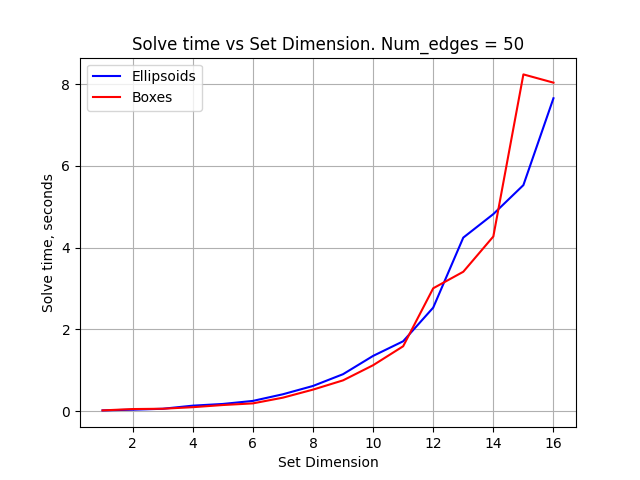

In [261]:
fig, ax = plt.subplots()
ax.plot(range(1,17), times_ellipsoid, color="blue", label = "Ellipsoids")
ax.plot(range(1,17), times_boxes, color="red", label = "Boxes")
ax.set_xlabel("Set Dimension")
ax.set_ylabel("Solve time, seconds")
ax.set_title("Solve time vs Set Dimension. Num_edges = 50")
ax.legend()
ax.grid()

In [9]:
def num_vertices_study(generator_function, n = 6, num_vertices_list = list(range(50,210,25)) ):
    times = []
    for num_vertices in num_vertices_list:
        prog = generator_function(n, num_vertices)
        dts = 0
        for i in range(3):
            timer = timeit()
            solution = Solve(prog)
            dts += timer.dt(print_stuff=False)
        dt = dts/3
        print(str(num_vertices) + " " + str(solution.is_success()) + " " + str(dt) + "\t" + str(solution.get_optimal_cost()))
        times.append(dt)
    return times

ellipsoid_nv = num_vertices_study( make_ellipsoid_cycle, n = 6, num_vertices_list= list(range(50,110,10))  )
boxes_nv = num_vertices_study( make_box_cycle, n = 6, num_vertices_list= list(range(50,110,10))  )

50 True 0.7360843022664388	-11.760000965176793
60 True 1.7526470025380452	-14.160015728936699
70 True 1.5710167090098064	-16.56099204535336
80 True 2.4341827233632407	-18.96011861443081
90 True 2.041818698247274	-21.42216218336631
100 True 2.0319687525431314	-24.016893496058486
50 False 1.2169622580210369	-0.5850264239457723
60 False 0.9231107234954834	-1.441405493606506
70 False 1.4361939430236816	-1.4351472663774096
80 False 1.3322402636210124	-4.082025957950081
90 False 1.4531737168629963	-3.8271823381612418
100 False 1.6069636344909668	-5.764200265009992


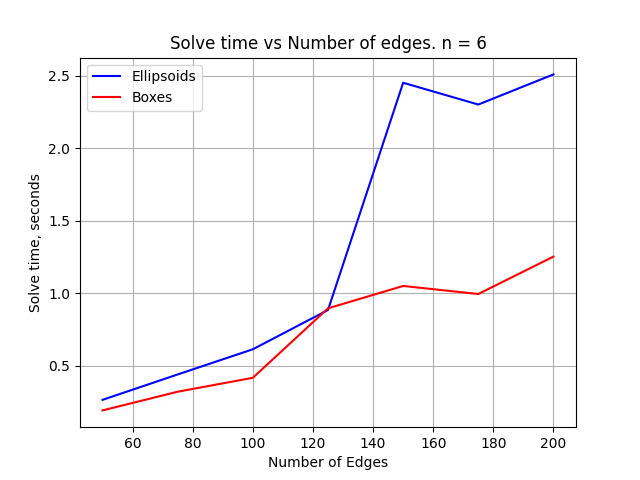

In [267]:
fig, ax = plt.subplots()
ax.plot(list(range(50,110,10)), ellipsoid_nv, color="blue", label = "Ellipsoids")
ax.plot(list(range(50,110,10)), boxes_nv, color="red", label = "Boxes")
ax.set_xlabel("Number of Edges")
ax.set_ylabel("Solve time, seconds")
ax.set_title("Solve time vs Number of edges. n = 6")
ax.legend()
ax.grid()

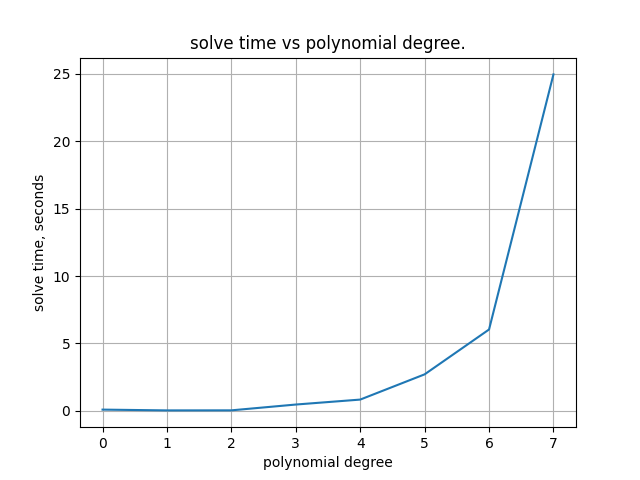